In [1]:
import pandas as pd
import numpy as np

import spacy

from gensim import corpora
from gensim.models import Word2Vec
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from sklearn.cluster import KMeans
from collections import Counter

from sentence_transformers import SentenceTransformer
from torch.nn.functional import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

# Load spacy model
nlp = spacy.load('en_core_web_sm')

import warnings
warnings.filterwarnings("ignore")

C:\Users\melod\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\melod\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
c:\Users\melod\anaconda3\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
from groq import Groq
import dotenv
import os

dotenv.load_dotenv()

True

In [4]:
from procedure import get_number_topics_subcategory, calculate_num_topics_star_rating, generate_topic_label, similarity_scores

## Metrics
1. Perplexity: metric used in topic modeling to evaluate how well the model generalizes to unseen data. Measures how likely the model is to assign high probabilities to the words in a test set based on the learned topics. Lower perplexity = better generalization
2. Coherence score: quality of the topics by measuring the semantic similarity of the top words in each topic. Higher coherence scores indicate that the words in the topic are more related, which generally leads to better interpretability. Usually between 0-1, higher than 0.4 is good.
3. Topic diversity: how distinct the topics are from each other. Usually between 0-1, above 0.7 is good. 

In [5]:
groq_api_key = os.getenv("GROQ_API_KEY")
print(groq_api_key)

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


In [8]:
# Sample data
df = pd.read_csv("./data/processed_reviews.csv")
# subcategories = ['SPRAY CLEANERS BLEACH CLEANERS', 'BODY CARE BODY LOTION', 'WOOD/FURNITURE/DUST', 'WOOD/FURNITURE CLEANER']
subcategories = ['SPRAY CLEANERS BLEACH CLEANERS']
df_sample = df[df['subcategory'].isin(subcategories)]

In [10]:
df_sample['lda2vec_topic_id'] = -1
df_sample['lda2vec_topic_label'] = ''
df_sample['lda2vec_topic_words'] = ''
df_sample['lda2vec_words_similarity_score'] = -1
df_sample['lda2vec_label_similarity_score'] = -1

grouped = df_sample.groupby(['subcategory', 'star_rating'])

# Loop through each (subcategory, star_rating) group
for (subcategory, star_rating), group in grouped:
    # STEP 1: Train LDA model to get topic distributions for each document
    # Preprocess the documents
    def create_custom_stopwords(df):
        unique_words = set()
        df['product_title'].drop_duplicates().str.split().apply(unique_words.update)
        df['brand'].drop_duplicates().str.split().apply(unique_words.update)
        unique_words = list(unique_words)

        custom_stopwords = unique_words + [word.lower() for word in unique_words] + [
            word.upper() for word in unique_words] + [word.capitalize() for word in unique_words]
        custom_stopwords = list(set(custom_stopwords))

        return custom_stopwords
    
    custom_stopwords = create_custom_stopwords(group)
    texts = [[word.text for word in nlp(doc.lower()) if not word.is_stop and word.text not in custom_stopwords] for doc in group['review_text']]

    # Create a dictionary and corpus for LDA
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    # subcategory size 
    subcategory_size = df_sample[df_sample['subcategory']==subcategory].shape[0]
    # size of current subcategory and star rating
    group_size = group.shape[0]

    # get total number of topics for the entire subcategory
    total_topics = get_number_topics_subcategory(subcategory_size)
    print(f"Assigning {total_topics} topics for subcategory {subcategory}")

    # Calculate the number of topics based on the size of the group
    num_topics = calculate_num_topics_star_rating(total_topics, star_rating)
    print(f"Assigning {num_topics} topics for {group_size} reviews (star rating {star_rating}) in subcategory {subcategory}")

    # Train the LDA model
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=15)

    # Get the topic distribution for each document
    doc_topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]
    
    ## STEP 2: train word2vec model
    word2vec_model = Word2Vec(sentences=texts, vector_size=100, window=5, min_count=1, sg=1, epochs=50)
    word_vectors = word2vec_model.wv

    ## STEP 3: Convert topic distributions to vectors
    # Create a matrix to hold topic embeddings (you can initialize randomly or train separately)
    topic_embeddings = np.random.rand(lda_model.num_topics, word2vec_model.vector_size)

    # Function to convert a topic distribution to a vector
    def get_topic_vector(topic_distribution):
        vec = np.zeros(word2vec_model.vector_size)
        for topic_id, weight in topic_distribution:
            vec += weight * topic_embeddings[topic_id]
        return vec

    # Get topic vectors for each document
    doc_topic_vectors = [get_topic_vector(dist) for dist in doc_topic_distributions]

    ## STEP 4: Combine topic vectors and word vectors
    # Function to get average word vector for a document
    def get_word_vector(text):
        words = [word for word in text if word in word_vectors]
        if words:
            return np.mean([word_vectors[word] for word in words], axis=0)
        else:
            return np.zeros(word2vec_model.vector_size)

    # Combine topic vector and word vector to get a document vector
    doc_vectors = []
    for text, topic_vec in zip(texts, doc_topic_vectors):
        word_vec = get_word_vector(text)
        doc_vec = word_vec + topic_vec  # Combining topic and word vectors
        doc_vectors.append(doc_vec)
        
    # STEP 5: Cluster the Document Vectors
    kmeans = KMeans(n_clusters=num_topics, random_state=42)
    cluster_labels = kmeans.fit_predict(doc_vectors)
    
    # STEP 6: Analyze Topics in Each Cluster
    print(f"\nCluster analysis for subcategory '{subcategory}' with star rating '{star_rating}':")
    
    lda2vec_topic_labels = []
    lda2vec_topic_words = []
    for cluster_id in range(num_topics):

        # Filter documents belonging to this cluster
        cluster_docs = [texts[i] for i in range(len(texts)) if cluster_labels[i] == cluster_id]

        # Get top 15 most frequent words in this cluster for interpretation
        all_words = [word for doc in cluster_docs for word in doc]
        most_common_words = Counter(all_words).most_common(15)
        common_words = ", ".join([word for word, freq in most_common_words])
        lda2vec_topic_words.append(common_words)
            
        # Refine the topic label using Groq API
        lda2vec_topic_label = generate_topic_label(common_words, star_rating)
        lda2vec_topic_labels.append(lda2vec_topic_label)
    print(lda2vec_topic_labels)


    # STEP 7: Calculate similarity scores and map values back to DataFrame
    for idx, doc_id in enumerate(group.index):
        cluster_id = cluster_labels[idx]
        lda2vec_topic_label = lda2vec_topic_labels[cluster_id]
        lda2vec_topic_words_text = lda2vec_topic_words[cluster_id]

        # Calculate similarity scores between review and topic words using similarity_scores function
        # lda2vec_words_similarity_score = similarity_scores('all-MiniLM-L6-v2', [group.loc[doc_id, 'review_text']], [lda2vec_topic_words_text])[0]
        # # print(lda2vec_words_similarity_score)

        # # Calculate similarity scores between review and topic label using similarity_scores function
        # lda2vec_label_similarity_score = similarity_scores('all-MiniLM-L6-v2', [group.loc[doc_id, 'review_text']], [lda2vec_topic_label])[0]

        # Assign values to DataFrame 
        df_sample.at[doc_id, 'lda2vec_topic_id'] = cluster_id
        df_sample.at[doc_id, 'lda2vec_topic_label'] = lda2vec_topic_label
        df_sample.at[doc_id, 'lda2vec_topic_words'] = lda2vec_topic_words_text
        # df_sample.at[doc_id, 'lda2vec_words_similarity_score'] = lda2vec_words_similarity_score
        # df_sample.at[doc_id, 'lda2vec_label_similarity_score'] = lda2vec_label_similarity_score


Assigning 6 topics for subcategory SPRAY CLEANERS BLEACH CLEANERS
Assigning 2 topics for 272 reviews (star rating 1.0) in subcategory SPRAY CLEANERS BLEACH CLEANERS

Cluster analysis for subcategory 'SPRAY CLEANERS BLEACH CLEANERS' with star rating '1.0':
['"Leaking or damaged product, poor experience"', '"Leaking or damaged products when using or receiving"']
Assigning 6 topics for subcategory SPRAY CLEANERS BLEACH CLEANERS
Assigning 2 topics for 97 reviews (star rating 2.0) in subcategory SPRAY CLEANERS BLEACH CLEANERS

Cluster analysis for subcategory 'SPRAY CLEANERS BLEACH CLEANERS' with star rating '2.0':
['"Product not effective at cleaning or lasting long time, with strong odor issues"', '"Leaking issues with some products, others pleasurable to use"']
Assigning 6 topics for subcategory SPRAY CLEANERS BLEACH CLEANERS
Assigning 2 topics for 165 reviews (star rating 3.0) in subcategory SPRAY CLEANERS BLEACH CLEANERS

Cluster analysis for subcategory 'SPRAY CLEANERS BLEACH CLEANERS

In [11]:
# def topic_modeling_with_labels(df, client, model):
#     # Group by subcategory and star_rating
#     grouped = df.groupby(['subcategory', 'star_rating'])
    
#     # Dictionary to store topic labels for each (subcategory, star_rating) group
#     topic_label_mapping = {}
    
#     # Loop through each (subcategory, star_rating) group
#     for (subcategory, star_rating), group in grouped:
#         print(f"Processing subcategory: {subcategory} with star rating: {star_rating}")
        
#         # Total size of the subcategory (for proportional topic assignment)
#         subcategory_size = df[df['subcategory'] == subcategory].shape[0]
#         group_size = group.shape[0]

#         # Get the total number of topics for the entire subcategory
#         total_topics = get_number_topics_subcategory(subcategory_size)
#         print(f"Assigning {total_topics} topics for subcategory {subcategory}")
        
#         # Calculate the number of topics based on the size of the group
#         num_topics = calculate_num_topics_star_rating(total_topics, star_rating)
#         print(f"Assigning {num_topics} topics for {group_size} reviews (star rating {star_rating}) in subcategory {subcategory}")
        
#         # Dictionary and corpus for LDA
#         dictionary = Dictionary(group['tokens'])
#         corpus = [dictionary.doc2bow(text) for text in group['tokens']]
        
#         # Train the LDA model
#         lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)

#         # Evaluate perplexity
#         # perplexity = lda_model.log_perplexity(corpus)
#         # print(f"Perplexity for subcategory {subcategory}, star rating {star_rating}: {perplexity}")

#         # Evaluate coherence score
#         # coherence_model = CoherenceModel(model=lda_model, texts=group['tokens'], dictionary=dictionary, coherence='c_v')
#         # coherence_score = coherence_model.get_coherence()
#         # print(f"Coherence Score for subcategory {subcategory}, star rating {star_rating}: {coherence_score}")
        
#         # Extract the top words for each topic
#         lda_topics = lda_model.show_topics(num_topics=num_topics, num_words=15, formatted=False)
        
#         # Refine topic labels using Groq API
#         lda2vec_topic_labels = []
#         for topic_id, topic_words in lda_topics:
#             # Extract the words from the topic tuple
#             topic_word_list = [word for word, _ in topic_words]
            
#             # Refine the topic label using Groq API
#             lda2vec_topic_label = refine_topic(client, model, topic_word_list, star_rating)
#             lda2vec_topic_labels.append(lda2vec_topic_label)
#             # print(f"Refined Label for Topic {topic_id}: {lda2vec_topic_label}")
        
#         # Create a mapping from LDA topic ID to the refined topic label
#         for topic_id, label in enumerate(lda2vec_topic_labels):
#             topic_label_mapping[(subcategory, star_rating, topic_id)] = label
        
#         # topic_diversity = calculate_topic_diversity(lda_topics)
#         # print(f"Topic Diversity for subcategory {subcategory}, star rating {star_rating}: {topic_diversity}")
        
#         # Add LDA topics to the original DataFrame using .loc[]
#         df.loc[group.index, 'LDA_topic'] = [max(lda_model.get_document_topics(doc), key=lambda x: x[1])[0] for doc in corpus]
    
#         # Debugging: Print all keys in the mapping to check for missing keys
#         print(f"Keys in topic_label_mapping: {list(topic_label_mapping.keys())}")

#         # Now, map the refined topic labels back to the original DataFrame
#         df['LDA2Vec_topic_label'] = df.apply(
#             lambda row: topic_label_mapping.get(
#                 (row['subcategory'], row['star_rating'], row['LDA_topic']),
#                 "Unknown Topic"  # Default value for missing keys
#             ), 
#             axis=1
#         )
    
#     return df

# # Apply the function to add the topic labels to df_sample
# df_sample = topic_modeling_with_labels(df_sample, client, model)


In [12]:
df_sample.columns

Index(['brand', 'product_title', 'proxy_date', 'retailer', 'category',
       'subcategory', 'review_text', 'star_rating', 'topic', 'brand_type',
       'lda2vec_topic_id', 'lda2vec_topic_label', 'lda2vec_topic_words',
       'lda2vec_words_similarity_score', 'lda2vec_label_similarity_score'],
      dtype='object')

In [14]:
subcategories = ['SPRAY CLEANERS BLEACH CLEANERS']
for subcategory in subcategories:
    df_subcategory = df_sample[df_sample['subcategory']==subcategory]
    for brand_type in df_subcategory['brand_type'].unique():
        df_brand = df_subcategory[df_subcategory['brand_type']==brand_type]
        print(f"Topics for subcategory: {subcategory} and brand: {brand_type}")
        print(df_brand['lda2vec_topic_label'].value_counts())
        print(" ")

Topics for subcategory: SPRAY CLEANERS BLEACH CLEANERS and brand: Clorox
lda2vec_topic_label
"Best product for great kitchen cleaning, good stain removal, and lovely smell."     3503
"Effective bathroom product with strong, pleasant scent"                              199
"Great product for bathroom use, easy to apply and clean surface"                     189
"Leaking or damaged product, poor experience"                                         150
"Leaking or damaged products when using or receiving"                                  95
"Product works well, slight odor and leak issues"                                      83
Good product, but lacks longevity.                                                     60
"Product not effective at cleaning or lasting long time, with strong odor issues"      44
"Leaking issues with some products, others pleasurable to use"                         37
Name: count, dtype: int64
 
Topics for subcategory: SPRAY CLEANERS BLEACH CLEANERS and brand: Com

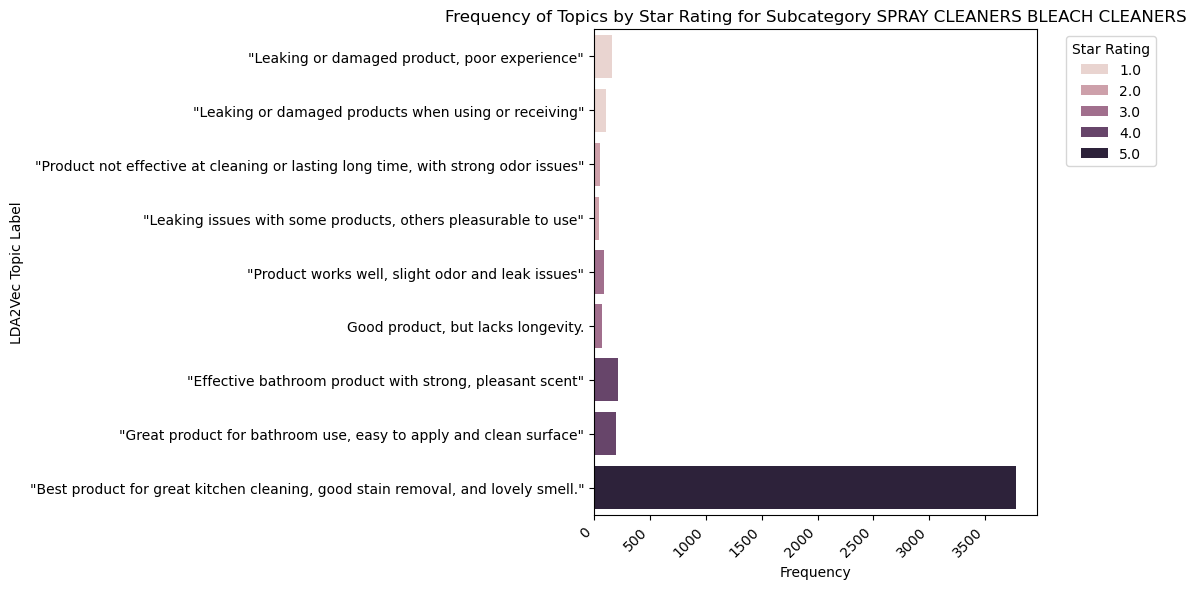

In [17]:
for subcategory in subcategories:
    df_subcategory = df_sample[df_sample['subcategory']==subcategory]
    df_subcategory_grouped_df = df_subcategory.groupby('star_rating')['lda2vec_topic_label'].value_counts().reset_index(name='count')
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_subcategory_grouped_df, x='count', y='lda2vec_topic_label', hue='star_rating', dodge=False)

    # Customize the plot
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Frequency of Topics by Star Rating for Subcategory {subcategory}')
    plt.xlabel('Frequency')
    plt.ylabel('LDA2Vec Topic Label')
    plt.legend(title='Star Rating', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Display the plot
    plt.tight_layout()
    plt.show()

In [68]:
def similarity_scores(model_name, df):
   model = SentenceTransformer(model_name)
   reviews = df['review_text'].tolist()
   phrases = df['lda2vec_topic_label'].tolist()
   review_embeddings = model.encode(reviews, convert_to_tensor=True)
   phrase_embeddings = model.encode(phrases, convert_to_tensor=True)
   similarity_scores = cosine_similarity(review_embeddings, phrase_embeddings).cpu().numpy()
   return similarity_scores

In [69]:
similarity_scores = similarity_scores('all-MiniLM-L6-v2', df_sample)

c:\Users\melod\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [70]:
print(similarity_scores)

[0.07160603 0.5449707  0.2668787  ... 0.3847584  0.3785109  0.48870254]


In [71]:
# add similarity scores to dataframe
df_sample['similarity_score'] = similarity_scores

C:\Users\melod\AppData\Local\Temp\ipykernel_48984\55219579.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['similarity_score'] = similarity_scores


In [72]:
df_sample['similarity_score'].mean()

0.41844365

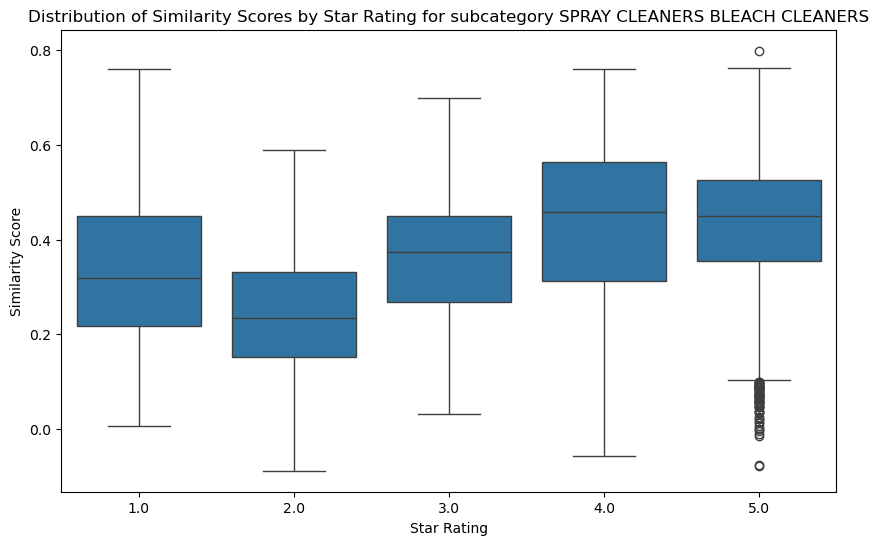

In [73]:
for subcategory in subcategories:
    df_subcategory = df_sample[df_sample['subcategory']==subcategory]
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_subcategory, x='star_rating', y='similarity_score')
    plt.title(f'Distribution of Similarity Scores by Star Rating for subcategory {subcategory}')
    plt.xlabel('Star Rating')
    plt.ylabel('Similarity Score')
    plt.show()

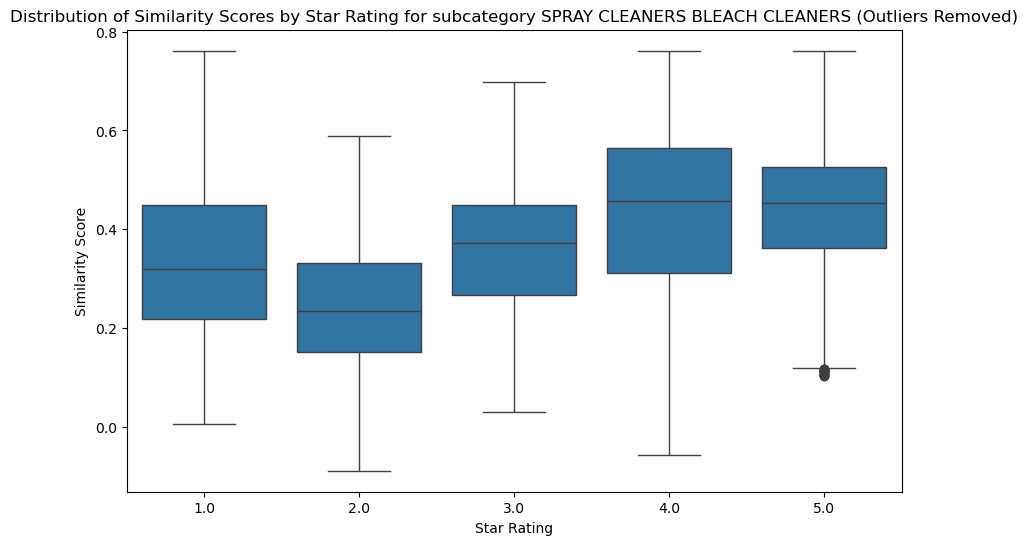

In [74]:
# similarity scores without outliers
filtered_df = pd.DataFrame()  # Initialize an empty DataFrame to store filtered data

for subcategory in subcategories:
    df_subcategory = df_sample[df_sample['subcategory'] == subcategory]
    
    for star_rating in df_subcategory['star_rating'].unique():
        df_rating = df_subcategory[df_subcategory['star_rating'] == star_rating]
        
        # Calculate Q1, Q3, and IQR for similarity_score
        Q1 = df_rating['similarity_score'].quantile(0.25)
        Q3 = df_rating['similarity_score'].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out the outliers
        df_filtered = df_rating[(df_rating['similarity_score'] >= lower_bound) & (df_rating['similarity_score'] <= upper_bound)]
        
        # Append filtered data to the new DataFrame
        filtered_df = pd.concat([filtered_df, df_filtered])

# Plot boxplot without outliers
for subcategory in subcategories:
    df_subcategory = filtered_df[filtered_df['subcategory'] == subcategory]
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_subcategory, x='star_rating', y='similarity_score')
    plt.title(f'Distribution of Similarity Scores by Star Rating for subcategory {subcategory} (Outliers Removed)')
    plt.xlabel('Star Rating')
    plt.ylabel('Similarity Score')
    plt.show()


In [36]:
df_sample.columns

Index(['brand', 'product_title', 'proxy_date', 'retailer', 'category',
       'subcategory', 'review_text', 'star_rating', 'topic', 'brand_type',
       'tokens', 'LDA_topic', 'LDA2Vec_topic_label', 'similarity_score'],
      dtype='object')

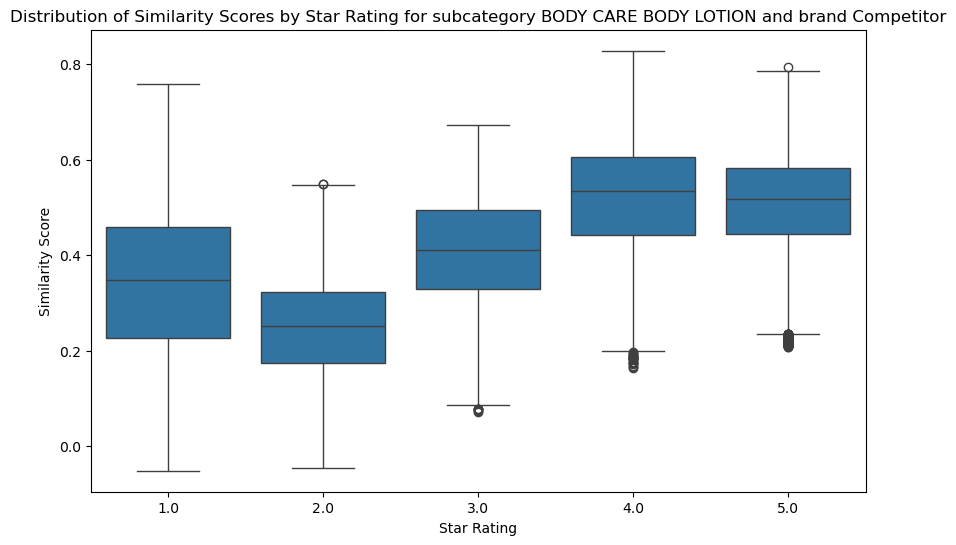

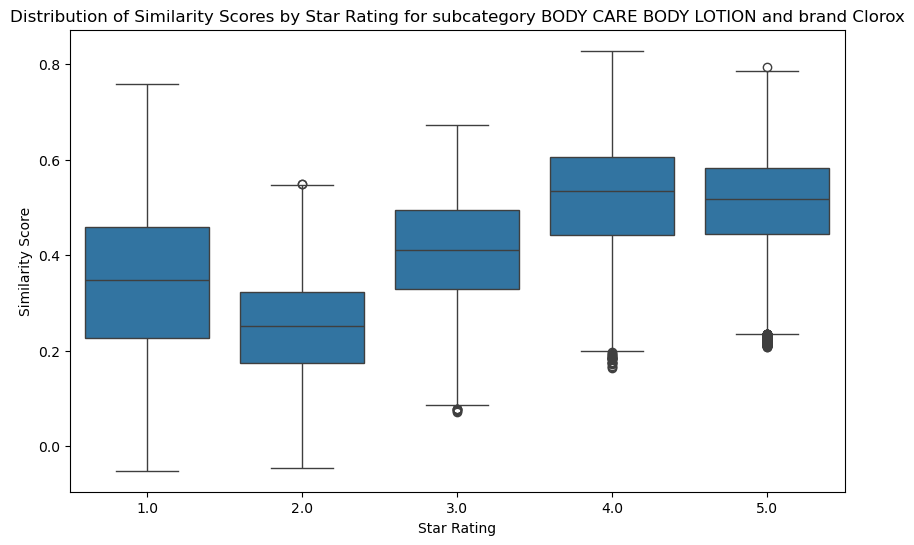

In [38]:
# similarity scores without outliers
filtered_df = pd.DataFrame()  # Initialize an empty DataFrame to store filtered data

for subcategory in subcategories:
    df_subcategory = df_sample[df_sample['subcategory'] == subcategory]
    
    for star_rating in df_subcategory['star_rating'].unique():
        df_rating = df_subcategory[df_subcategory['star_rating'] == star_rating]
        
        # Calculate Q1, Q3, and IQR for similarity_score
        Q1 = df_rating['similarity_score'].quantile(0.25)
        Q3 = df_rating['similarity_score'].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out the outliers
        df_filtered = df_rating[(df_rating['similarity_score'] >= lower_bound) & (df_rating['similarity_score'] <= upper_bound)]
        
        # Append filtered data to the new DataFrame
        filtered_df = pd.concat([filtered_df, df_filtered])

# Plot boxplot without outliers
for subcategory in subcategories:
    df_subcategory = filtered_df[filtered_df['subcategory'] == subcategory]
    for brand in df_subcategory['brand_type'].unique():
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df_subcategory, x='star_rating', y='similarity_score')
        plt.title(f'Distribution of Similarity Scores by Star Rating for subcategory {subcategory} and brand {brand}')
        plt.xlabel('Star Rating')
        plt.ylabel('Similarity Score')
        plt.show()


In [75]:
outliers = []

for subcategory in subcategories:
    df_subcategory = df_sample[df_sample['subcategory'] == subcategory]
    
    for star_rating in df_subcategory['star_rating'].unique():
        df_rating = df_subcategory[df_subcategory['star_rating'] == star_rating]
        
        # Calculate Q1, Q3, and IQR
        Q1 = df_rating['similarity_score'].quantile(0.25)
        Q3 = df_rating['similarity_score'].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out outliers
        df_outliers = df_rating[(df_rating['similarity_score'] < lower_bound) | (df_rating['similarity_score'] > upper_bound)]
        
        # Append the outliers with additional details
        if not df_outliers.empty:
            outliers.append({
                'subcategory': subcategory,
                'star_rating': star_rating,
                'outliers': df_outliers[['review_text', 'similarity_score']]
            })

# Display the outliers for each subcategory and star rating
for outlier_info in outliers:
    print(f"Outliers in subcategory '{outlier_info['subcategory']}' with star rating {outlier_info['star_rating']}:")
    print(outlier_info['outliers'])

Outliers in subcategory 'SPRAY CLEANERS BLEACH CLEANERS' with star rating 5.0:
                                              review_text  similarity_score
11                   it do the work that be enough for me          0.071606
3645                     serve the purpose get the job do          0.094993
4133    i get everything i want 26 the price be reason...          0.056112
4371                                       luv this stuff          0.092794
4486    bang for my buck i get two for less than 10 de...          0.035946
...                                                   ...               ...
194695      do the job and the price be right up my alley          0.091449
197494                          last me about half a year          0.099954
197928                                  it work perfectly          0.099682
199603                         buy in bulk to reduce cost          0.057198
200074  hello stephanie weve if i loose it all if i lo...          0.011703

[75 rows

In [ ]:
outliers = []

for subcategory in subcategories:
    df_subcategory = df_sample[df_sample['subcategory'] == subcategory]
    
    for star_rating in df_subcategory['star_rating'].unique():
        df_rating = df_subcategory[df_subcategory['star_rating'] == star_rating]
        
        # Calculate Q1, Q3, and IQR
        Q1 = df_rating['similarity_score'].quantile(0.25)
        Q3 = df_rating['similarity_score'].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out outliers
        df_outliers = df_rating[(df_rating['similarity_score'] < lower_bound) | (df_rating['similarity_score'] > upper_bound)]
        
        # Append the outliers with additional details
        if not df_outliers.empty:
            outliers.append({
                'subcategory': subcategory,
                'star_rating': star_rating,
                'outliers': df_outliers[['review_text', 'similarity_score']]
            })

# Display the outliers for each subcategory and star rating
for outlier_info in outliers:
    print(f"Outliers in subcategory '{outlier_info['subcategory']}' with star rating {outlier_info['star_rating']}:")
    print(outlier_info['outliers'])

In [21]:
def sample_by_star_rating(df, star_rating, sample_size):
    subset = df[df['star_rating'] == star_rating]
    return subset.sample(n=min(sample_size, len(subset)), random_state=42)

# Sample subsets for each star rating (1 to 5)
samples = [sample_by_star_rating(df_sample, rating, 5) for rating in range(1, 6)]

# Combine the sampled subsets into one DataFrame
sampled_df = pd.concat(samples, ignore_index=True)
sampled_df[['review_text', 'star_rating', 'LDA2Vec_topic_label']]

,review_text,star_rating,LDA2Vec_topic_label
0,it smell disgust and doesnt moisturize whatsoever,1.0,"""Old formula or new scent not used"""
1,if i be write this review last year i would be...,1.0,"""Not satisfied with product formula."""
2,mid smell overrate and doesnt last long,1.0,"""Not effective new lotion for dry skin"""
3,why be this change previously great product no...,1.0,"""Not satisfied with product formula."""
4,i think the lotion would probably be fine but ...,1.0,"""Old formula or new scent not used"""
5,i buy this think it be the same scent as the o...,2.0,"""Not as good on skin as expected"""
6,smell okay but the pump stop work after two us,2.0,"""Not good lotion use"""
7,this lotion for dry sensitive skin use to be e...,2.0,"""Not as good on skin as expected"""
8,great product terrible packaging please update...,2.0,Not a pleasant experience
9,i buy this because another reviewer say it sme...,2.0,Not a pleasant experience


In [22]:
df_sample.columns

Index(['brand', 'product_title', 'proxy_date', 'retailer', 'category',
       'subcategory', 'review_text', 'star_rating', 'topic', 'brand_type',
       'tokens', 'LDA_topic', 'LDA2Vec_topic_label', 'similarity_score'],
      dtype='object')

In [23]:
df['subcategory'].value_counts().head(50)

subcategory
FACE CARE FACIAL MOISTURIZERS                     81938
FACE CARE FACIAL CLEANSERS                        80514
FACE CARE ACNE TREATMENTS                         46202
FACE CARE FACIAL TOWELETTES                       43130
FACE CARE FACIAL TREATMENTS                       37345
BODY CARE BODY WASH                               28433
WIPES DISINFECTING WIPES                          22595
ODOR CONTROLLING DISINFECTING SPRAYS              20806
BODY CARE BODY LOTION                             20281
LIP CARE LIP BALM                                 19107
FLOOR CLEANERS CONVENIENCE                        17318
SPRAY CLEANERS ALL PURPOSE CLEANERS               16896
BODY CARE                                         14068
DRAIN CARE                                        12212
AIR FRESHENER                                     11161
DILUTABLES SCENTED/NON-DISINFECTING DILUTABLES    10754
ODOR CONTROLLING AIR FRESHENERS                    9877
CONSUMABLE TOOLS CONSUMABLE SCRUBBER

In [25]:
df_sample.columns

Index(['brand', 'product_title', 'proxy_date', 'retailer', 'category',
       'subcategory', 'review_text', 'star_rating', 'topic', 'brand_type',
       'tokens', 'LDA_topic', 'LDA2Vec_topic_label', 'similarity_score'],
      dtype='object')

In [26]:
df_sample.to_csv('../outputs/lda2vec_body_lotion.csv')

In [77]:
df_sample.to_csv('../outputs/lda2vec_spray_cleaners.csv')